## 3 Sentiment Analysis [40 points]

Sentiment analysis refers to the use of natural language processing to systematically identify, extract, quantify, and study affective states and subjective information. As shown in class it is widely applied to reviews and survey responses, and social media content for applications that range from marketing to customer service. In this problem, we will explore a basic task in sentiment analysis, which is classifying the polarity of a given text to be positive or negative.

For this problem, we will use the training data containing 10,000 Yelp restaurant reviews, where each review is labelled based on their ratings. Reviews for training dataset are in the corresponding folders (‘/neg’ for negative reviews and ‘/pos’ for positive reviews). Label the negative sentiment reviews from the /neg folder as 1 and the positive sentiment reviews from the /pos folder as 0, these 1 and 0 labels will be your target labels for sentiment analysis.

The training data is available at: http://bit.ly/2nuzyUM

You can use the following tools for implementation:
1. TensorFlow https://www.tensorflow.org/
2. Scikit-learn http://scikit-learn.org/stable/index.html
3. PyTorch http://pytorch.org/

In addition to output, results and your answers (in a file named Q3.txt), please submit your code along with a README file explaining how to run your code.

In [52]:
import glob
from sklearn.utils import shuffle
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import os

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
def load_train_data(input_directory):
    filenames = []
    data = []
    labels = []
    for filename in glob.glob(input_directory + "/*"):
#         print("Prepocessing: {}".format(file_name))
        filenames.append(filename[filename.rfind('/')+1:])
        file_pointer = open(filename, "r")

        # Read file contents
        file_content = file_pointer.read()
        data.append(file_content)
        file_pointer.close()
        
    # Get the labels
    if input_directory[input_directory.rfind('/')+1:] == 'neg':
        labels = [1] * len(data)
    else:
        labels = [0] * len(data)
    return filenames, data, labels

In [3]:
def load_test_data(input_directory):
    filenames = []
    data = []
    for filename in glob.glob(input_directory + "/*"):
#         print("Prepocessing: {}".format(file_name))
        filenames.append(filename[filename.rfind('/')+1:])
        file_pointer = open(filename, "r")

        # Read file contents
        file_content = file_pointer.read()
        data.append(file_content)
        file_pointer.close()
        
    return filenames, data

In [4]:
negative_filenames, negative_data, negative_labels = load_train_data('../input/training/neg')
positive_filenames, positive_data, positive_labels = load_train_data('../input/training/pos')
train_filenames = negative_filenames + positive_filenames
train_data = negative_data + positive_data
train_labels = negative_labels + positive_labels
train_filenames, train_data, train_labels = shuffle(train_filenames, train_data, train_labels, random_state=0)

In [5]:
test_filenames, test_data = load_test_data('../input/test')

In [6]:
train_data[0:2]

['By far my favorite lunch spot in the entire Phoenix area. The chopped salad & chicken pesto sandwich are my favorite. The desserts are delicious. Try the lunch special and you get an amazing little chocolate chip cookie!',
 'This place is keeping itself in business by promoting weekly and monthly recurring customers.  They play a video about diseases related to back troubles of which 75% would be thrown away by the American Medical Association. Some chiros will help you. They will not. I was told that one visit does nothing and repeat trips are the only way to get relief.  Nice receptionist, but morally bankrupt premise that their business is built on. Not practice. Business.']

In [7]:
len(train_labels)

10000

#### Support Functions

In [8]:
def get_cross_validation_sets(k, train_df):
    result = []
    size = train_df.shape[0]
    each_dev_set_size = int(size/k)
    for i in range(0, size, each_dev_set_size):
        if i == 0:
            result.append({
                'dev': (i, i+each_dev_set_size),
                'train': (i+each_dev_set_size, size),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[i+each_dev_set_size:size, :]
            })
        elif (i + each_dev_set_size) == size:
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': (0, i),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[0:i, :]
            })
        else:
            temp_train_df_1 = train_df.iloc[0:i, :]
            temp_train_df_2 = train_df.iloc[i+each_dev_set_size:size, :]
            temp_train_df = pd.concat([temp_train_df_1, temp_train_df_2])
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': [(0, i), (i+each_dev_set_size, size)],
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': temp_train_df
            })
            
    return result

In [9]:
def plot_accuracy(history):
    # Plotting the history of accuracy 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [10]:
def plot_loss(history):
    # Summarizing the history of loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [11]:
def get_model_template(input_dimensions, n1, activation_function):
    model = Sequential()
    model.add(Dense(n1, input_dim=input_dimensions, activation=activation_function))
    model.add(Dense(10, activation=activation_function))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
def train(model, x_train, y_train, x_test=None, y_test=None, save=False, model_name=None):
    model.summary()
    history = None
    if x_test is None:
        ## If validation/test set is not given
        print("Validation/Test set is not given")
        history = model.fit(x_train, y_train, epochs=10, batch_size=64)
    else:
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)
    
    if save == True:
        model.save('../output/'+model_name+'.h5')
    return model, history

In [13]:
def get_x_y(df):
    x = df[df.columns.difference(['y_label', 'filenameindex'])].values
    y = df[['y_label']].values
    return x,y

In [14]:
def get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions):
    temp_output_file = open(output_filename, 'w')
    temp_output_file.write('############################## \n\n\n')
    input_dimensions = cross_validation_sets[0]['train_df'].shape[1] - 2
    
    max_val_accuracy = 0
    selected_model_parameters = ()
    for n1 in neurons_in_layer_1:
        for activation_function in activation_functions:
            print('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            temp_output_file.write('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            cv_val_accuracy_list = []
            for i in range(len(cross_validation_sets)):
                cross_validation_set = cross_validation_sets[i]

                temp_output_file.write('Dev: {}, Trian: {}\n'.format(cross_validation_set['dev'], cross_validation_set['train']))
                print("Dev: {}, Train: {}".format(cross_validation_set['dev'], cross_validation_set['train']))

                train_df = cross_validation_set['train_df']
                train_x_df, train_y_df = get_x_y(train_df)
                dev_df = cross_validation_set['dev_df']
                dev_x_df, dev_y_df = get_x_y(dev_df)
                
                model = get_model_template(train_x_df.shape[1], n1, activation_function)
                model, history = train(model, train_x_df, train_y_df, dev_x_df, dev_y_df)
                plot_accuracy(history)
                plot_loss(history)
                              
                temp_output_file.write('Accuracy -- Dev: {}, Trian: {}\n'.format(history.history['val_accuracy'][-1], history.history['accuracy'][-1]))
                
                cv_val_accuracy_list.append(history.history['val_accuracy'][-1])
                
            mean_avg = sum(cv_val_accuracy_list) / len(cv_val_accuracy_list)
            temp_output_file.write('Accuracy ---- list: {}, mean: {}\n\n'.format(cv_val_accuracy_list, mean_avg))
            
            # Checking for best parameter
            if mean_avg > max_val_accuracy:
                max_val_accuracy = mean_avg
                selected_model_parameters = {
                    'val_accuracy':max_val_accuracy,
                    'n1': n1,
                    'n2': 10,
                    'activation': activation_function,
                    'n2_activation': 'sigmoid'
                }
     
    temp_output_file.write('Selected parameters: {}\n\n'.format(selected_model_parameters))
    temp_output_file.close()                              
    return selected_model_parameters                        

### 3.4 [10 points]
Compute training set’s review feature vector: i) first generate TF-IDF, and ii) then apply Singular value decomposition (SVD) on it. Do the same as described in 3.1: Use 10-fold cross-validation to optimize the SVD’s number of components and model’s parameters (e.g. activation function or number of nodes in the first hidden layer). Use accuracy as the metric for parameter selection.

Report the parameters of your best model. Then re-train the best performing model on the whole training set, and report the accuracy on the training set.

Hint: You can use the SVD implementation of Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html. The n components parameter is the number of components.

In [15]:
def svd_results(train_df, train_filenames, train_labels):
    train_x_df, train_y_df = get_x_y(train_df)
    
    activation_functions = ['relu', 'sigmoid', 'tanh']
    neurons_in_layer_1 = [2, 3]
    number_of_components = [500, 1000, 2000]
    
    selected_model_parameters = None
    for component in number_of_components:
        print("Component: {}".format(component))
        svd = TruncatedSVD(n_components=component, n_iter=7, random_state=42)
        train_x_transformed_array = svd.fit_transform(train_x_df)        
        
        # create a dataframe to reuse existing functions
        train_x_transformed_df = pd.DataFrame(train_x_transformed_array)
        train_x_transformed_df['y_label'] = train_labels
        train_x_transformed_df['filenameindex'] = train_filenames
        print(train_x_transformed_df.columns)
        
        output_filename = '../output/svd_'+str(component)+'.txt'
        print("Getting cross validation sets")
        
        cross_validation_sets = get_cross_validation_sets(10, train_x_transformed_df)
        
        print("Getting best parameter for component: {}".format(component))
        temp_selected_model_parameters = get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions)
        if selected_model_parameters is None:
            selected_model_parameters = temp_selected_model_parameters
            selected_model_parameters['components'] = component
        else:
            if temp_selected_model_parameters['val_accuracy'] > selected_model_parameters['val_accuracy']:
                selected_model_parameters = temp_selected_model_parameters 
                selected_model_parameters['components'] = component
        
        return selected_model_parameters

In [42]:
def run_3_4_1(train_filenames, train_data, train_labels, test_filenames, test_data):
    
     # Create the train dataframe
    vectorizer = TfidfVectorizer()
    csr_array = vectorizer.fit_transform(train_data+test_data).todense()
    feature_names = vectorizer.get_feature_names()
    df = pd.DataFrame(csr_array, columns=vectorizer.get_feature_names())
    train_df = df.iloc[:len(train_data), :]
    test_df = df.iloc[len(train_data): , :]
    
    train_df['y_label'] = train_labels
    train_df['filenameindex'] = train_filenames
    selected_model_parameters = svd_results(train_df, train_filenames, train_labels)
    
    test_df['y_label'] = -1
    test_df['filenameindex'] = test_filenames
    
    return train_df, test_df, feature_names, selected_model_parameters

In [43]:
def run_3_4_2(train_df, selected_model_parameters):
    
    train_x_df, train_y_df = get_x_y(train_df)
    
    # SVD
    svd = TruncatedSVD(n_components=selected_model_parameters['components'], n_iter=7, random_state=42)
    train_x_transformed_array = svd.fit_transform(train_x_df)        

    # create a dataframe to reuse existing functions
    train_x_transformed_df = pd.DataFrame(train_x_transformed_array)
    
    temp_output_file = open('../output/svd_result.txt', 'w')
    temp_output_file.write('Parameters: {}\n\n'.format(selected_model_parameters))
    model = get_model_template(train_x_transformed_df.shape[1], selected_model_parameters['n1'], selected_model_parameters['activation'])
    model, history = train(model, train_x_transformed_df, train_y_df, None, None, True, 'svd')
    temp_output_file.write('Train Accuracy: {}\n\n'.format(history.history['accuracy'][-1]))
    
    return svd

/Users/karangm/PycharmProjects/sentiment_analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/karangm/PycharmProjects/sentiment_analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Component: 500
Index([              0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,
       ...
                   492,             493,             494,             495,
                   496,             497,             498,             499,
             'y_label', 'filenameindex'],
      dtype='object', length=502)
Getting cross validation sets
Getting best parameter for component: 500
Input Dim: 500, n1: 2, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_730 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_731 (Dense)            (None, 10)                30        
________________

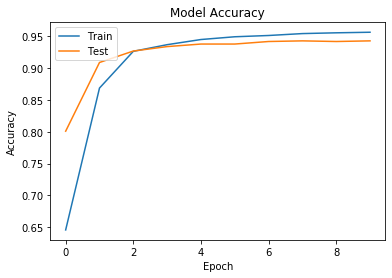

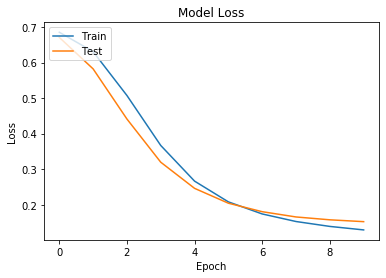

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_733 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_734 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_735 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 52us/step - loss: 0.6897 - accuracy: 0.5544 - val_loss: 0.6768 - val_accuracy: 0.7340
Epoch 2/10
9000/9000 [==============================] - 0s 24us/step - loss: 0.6200 - accuracy: 0.8359 - val_loss: 0.5534 - val_accura

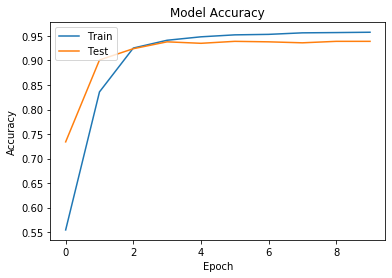

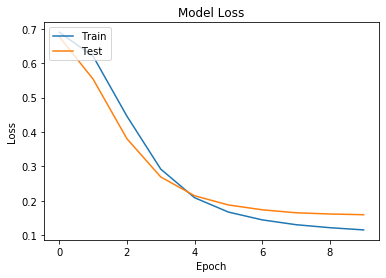

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_736 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_737 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_738 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 37us/step - loss: 0.6823 - accuracy: 0.6588 - val_loss: 0.6631 - val_accuracy: 0.7920
Epoch 2/10
9000/9000 [==============================] - 0s 19us/step - loss: 0.6094 - accuracy: 0.8743 - val_loss: 0.5518 - val_accura

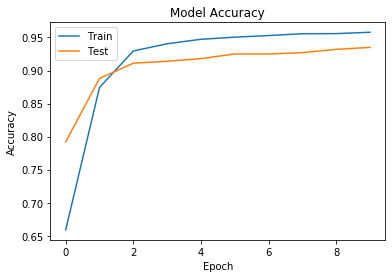

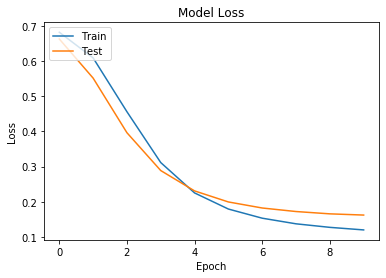

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_739 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_740 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_741 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 36us/step - loss: 0.6915 - accuracy: 0.5212 - val_loss: 0.6843 - val_accuracy: 0.6760
Epoch 2/10
9000/9000 [==============================] - 0s 19us/step - loss: 0.6569 - accuracy: 0.8030 - val_loss: 0.6147 - val_accura

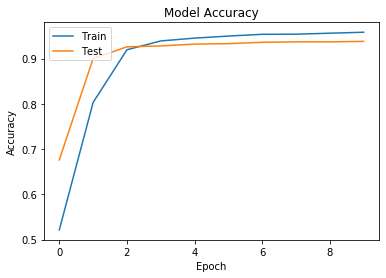

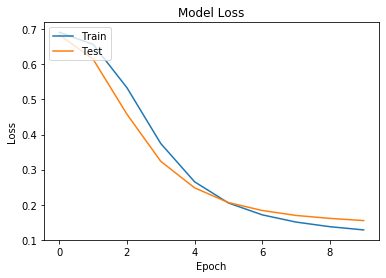

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_742 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_743 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_744 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.6861 - accuracy: 0.6273 - val_loss: 0.6662 - val_accuracy: 0.7830
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6135 - accuracy: 0.8769 - val_loss: 0.5548 - val_accura

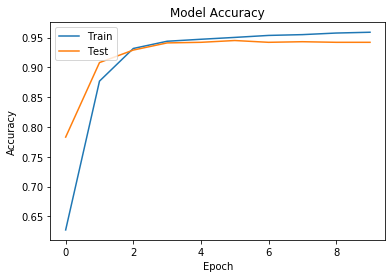

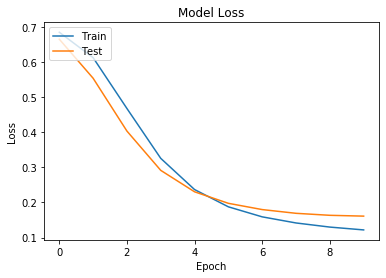

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_745 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_746 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_747 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6869 - accuracy: 0.5996 - val_loss: 0.6722 - val_accuracy: 0.6850
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6252 - accuracy: 0.8339 - val_loss: 0.5681 - val_accura

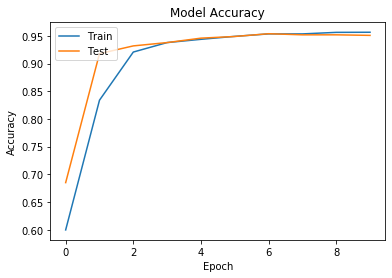

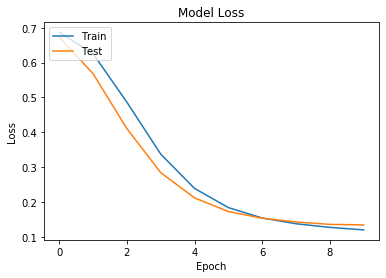

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_748 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_749 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_750 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6894 - accuracy: 0.5504 - val_loss: 0.6805 - val_accuracy: 0.6810
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6492 - accuracy: 0.7668 - val_loss: 0.5973 - val_accura

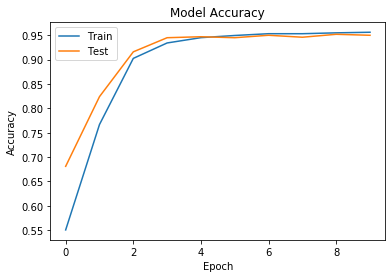

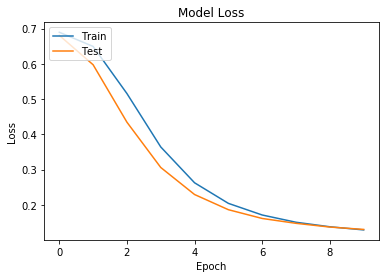

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_751 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_752 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_753 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6880 - accuracy: 0.5643 - val_loss: 0.6749 - val_accuracy: 0.6210
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6421 - accuracy: 0.6493 - val_loss: 0.5892 - val_accura

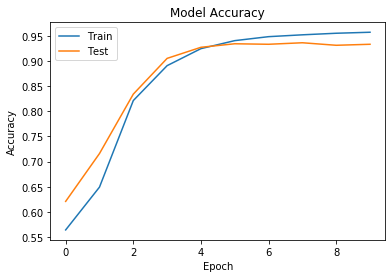

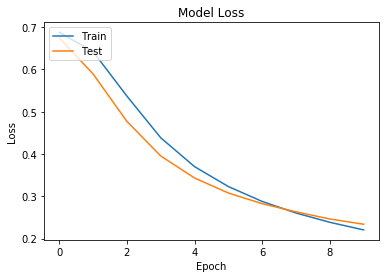

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_754 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_755 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_756 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6888 - accuracy: 0.5234 - val_loss: 0.6802 - val_accuracy: 0.5130
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6500 - accuracy: 0.6221 - val_loss: 0.6195 - val_accura

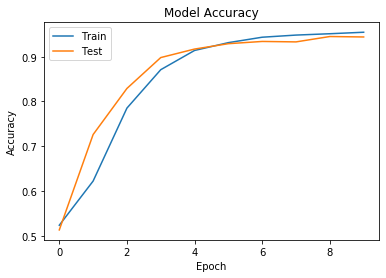

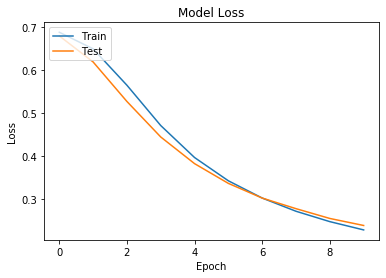

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_757 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_758 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_759 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6874 - accuracy: 0.5994 - val_loss: 0.6701 - val_accuracy: 0.7790
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6342 - accuracy: 0.7811 - val_loss: 0.5804 - val_accuracy: 0.8530
Epoch

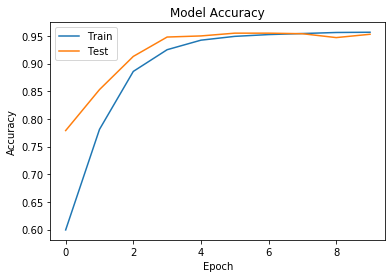

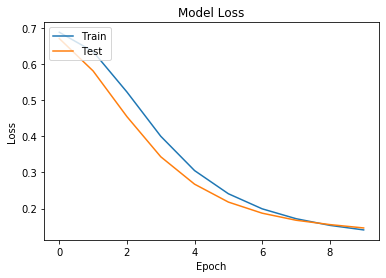

Input Dim: 500, n1: 2, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_760 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_761 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_762 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.6972 - accuracy: 0.5046 - val_loss: 0.6925 - val_accuracy: 0.7370
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step 

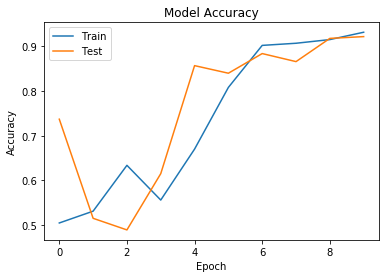

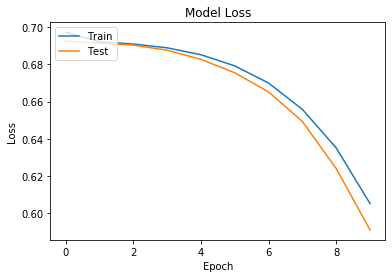

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_763 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_764 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_765 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6951 - accuracy: 0.5047 - val_loss: 0.6923 - val_accuracy: 0.4970
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6916 - accuracy: 0.5969 - val_loss: 0.6911 - val_accura

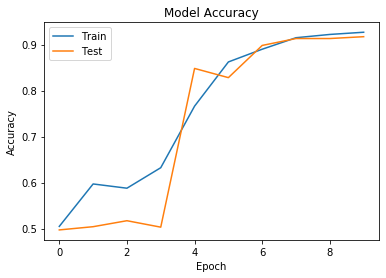

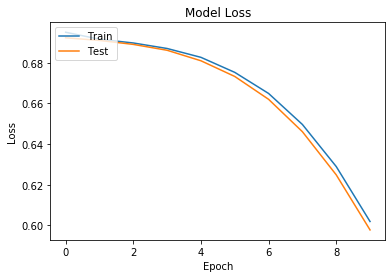

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_766 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_767 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_768 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 54us/step - loss: 0.6950 - accuracy: 0.5032 - val_loss: 0.6929 - val_accuracy: 0.6600
Epoch 2/10
9000/9000 [==============================] - 0s 27us/step - loss: 0.6929 - accuracy: 0.5014 - val_loss: 0.6933 - val_accura

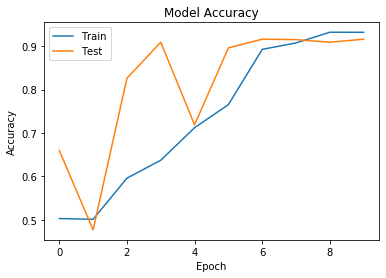

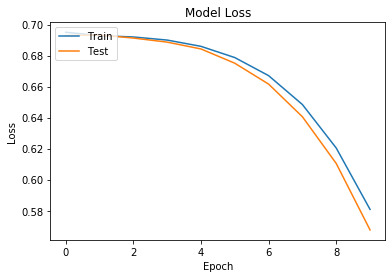

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_769 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_770 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_771 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 45us/step - loss: 0.7364 - accuracy: 0.4980 - val_loss: 0.6947 - val_accuracy: 0.5180
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.6939 - accuracy: 0.4980 - val_loss: 0.6916 - val_accura

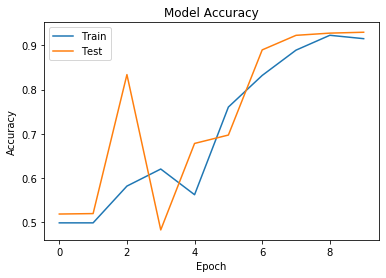

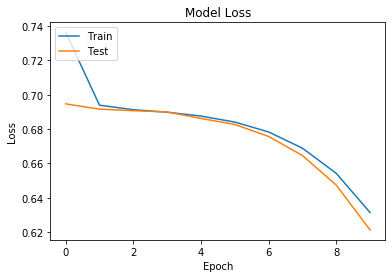

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_772 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_773 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_774 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.6977 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.4890
Epoch 2/10
9000/9000 [==============================] - 0s 21us/step - loss: 0.6925 - accuracy: 0.5054 - val_loss: 0.6919 - val_accura

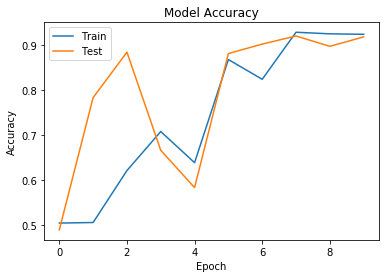

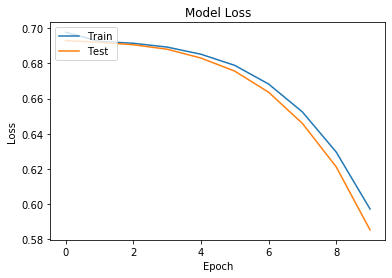

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_775 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_776 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_777 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6926 - val_accuracy: 0.5260
Epoch 2/10
9000/9000 [==============================] - 0s 25us/step - loss: 0.6927 - accuracy: 0.5277 - val_loss: 0.6925 - val_accura

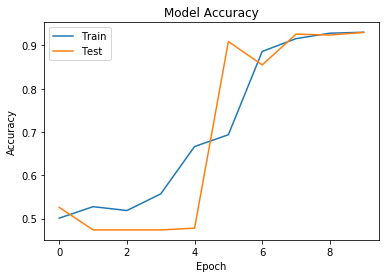

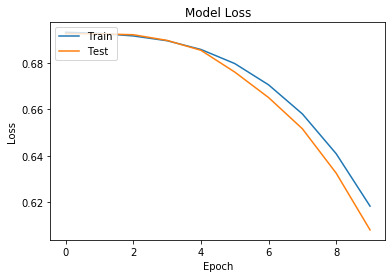

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_778 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_779 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_780 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 41us/step - loss: 0.6967 - accuracy: 0.5021 - val_loss: 0.6923 - val_accuracy: 0.5660
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.6917 - accuracy: 0.5232 - val_loss: 0.6911 - val_accura

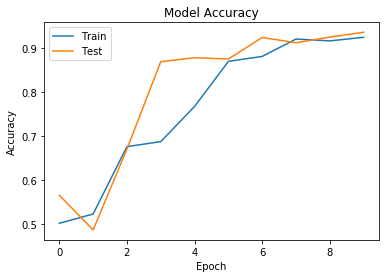

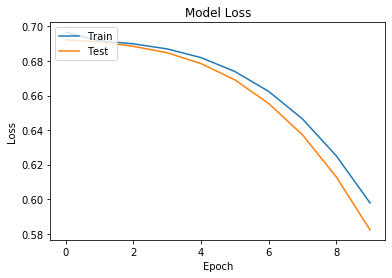

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_781 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_782 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_783 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 37us/step - loss: 0.6929 - accuracy: 0.5053 - val_loss: 0.6922 - val_accuracy: 0.5250
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6922 - accuracy: 0.5053 - val_loss: 0.6921 - val_accura

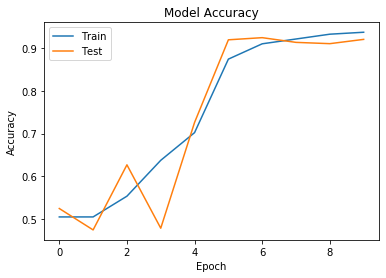

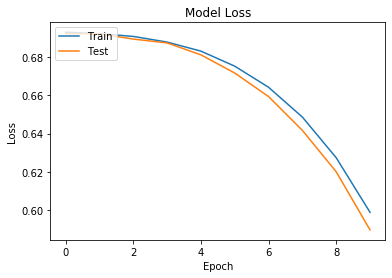

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_784 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_785 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_786 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.6930 - accuracy: 0.5159 - val_loss: 0.6918 - val_accuracy: 0.6810
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6913 - accuracy: 0.6186 - val_loss: 0.6905 - val_accura

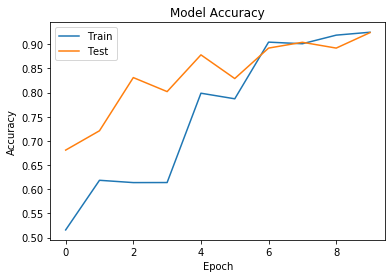

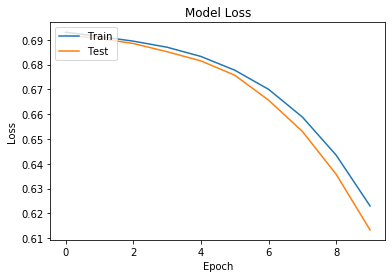

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_787 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_788 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_789 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.7939 - accuracy: 0.4983 - val_loss: 0.7109 - val_accuracy: 0.5150
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.7008 - accuracy: 0.4983 - val_loss: 0.6922 - val_accuracy: 0.5150
Epoch

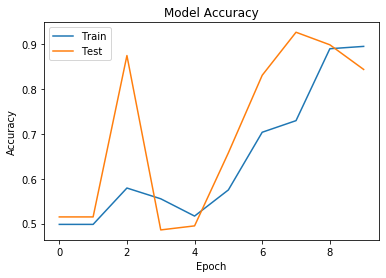

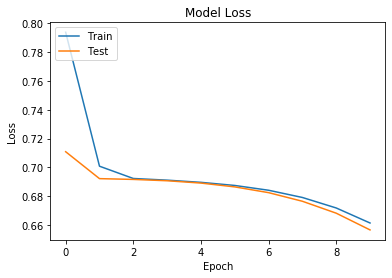

Input Dim: 500, n1: 2, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_790 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_791 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_792 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 38us/step - loss: 0.6804 - accuracy: 0.6546 - val_loss: 0.6561 - val_accuracy: 0.7540
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - l

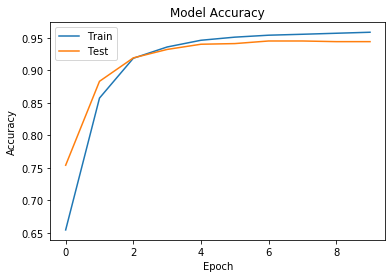

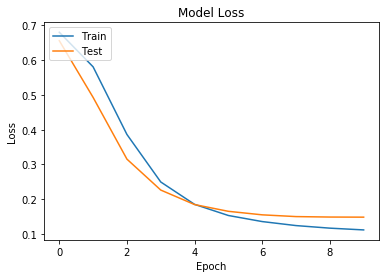

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_793 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_794 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_795 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 37us/step - loss: 0.6786 - accuracy: 0.6576 - val_loss: 0.6544 - val_accuracy: 0.7770
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5768 - accuracy: 0.8644 - val_loss: 0.5058 - val_accura

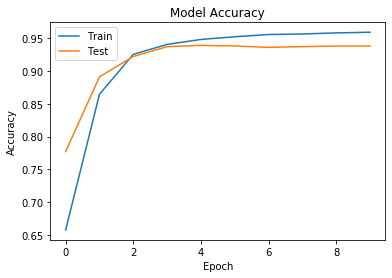

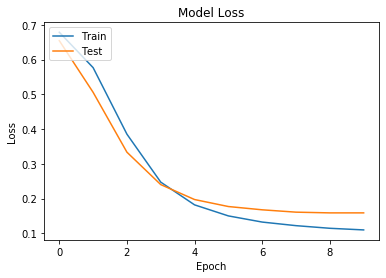

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_796 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_797 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_798 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 36us/step - loss: 0.6815 - accuracy: 0.6326 - val_loss: 0.6568 - val_accuracy: 0.7450
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5864 - accuracy: 0.8601 - val_loss: 0.5050 - val_accura

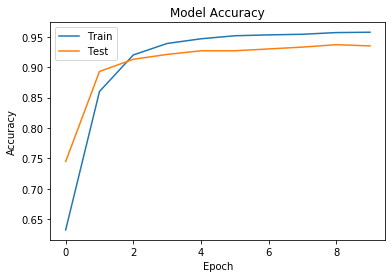

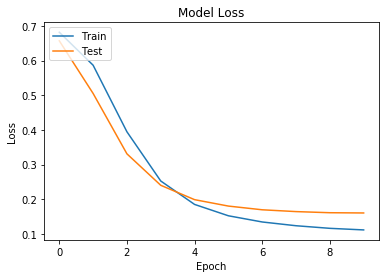

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_799 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_800 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_801 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6821 - accuracy: 0.6516 - val_loss: 0.6565 - val_accuracy: 0.7770
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5851 - accuracy: 0.8604 - val_loss: 0.5034 - val_accura

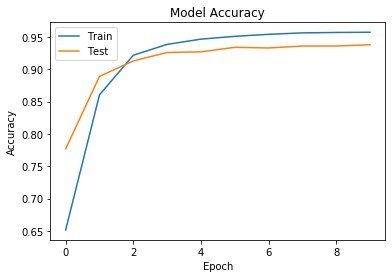

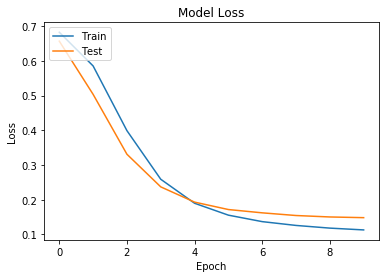

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_802 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_803 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_804 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6777 - accuracy: 0.6502 - val_loss: 0.6531 - val_accuracy: 0.7380
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5915 - accuracy: 0.8442 - val_loss: 0.5117 - val_accura

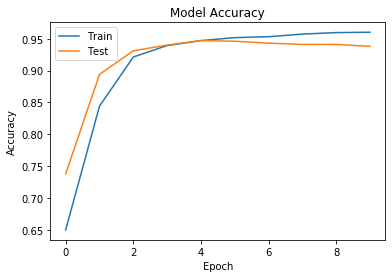

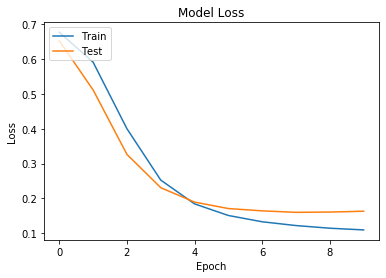

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_805 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_806 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_807 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 51us/step - loss: 0.6828 - accuracy: 0.6070 - val_loss: 0.6543 - val_accuracy: 0.8260
Epoch 2/10
9000/9000 [==============================] - 0s 26us/step - loss: 0.5754 - accuracy: 0.8842 - val_loss: 0.4815 - val_accura

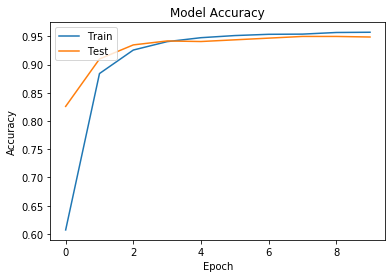

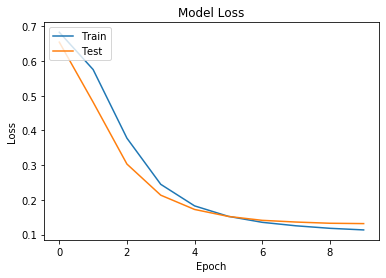

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_808 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_809 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_810 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6835 - accuracy: 0.6441 - val_loss: 0.6593 - val_accuracy: 0.8160
Epoch 2/10
9000/9000 [==============================] - 0s 27us/step - loss: 0.5905 - accuracy: 0.8586 - val_loss: 0.4992 - val_accura

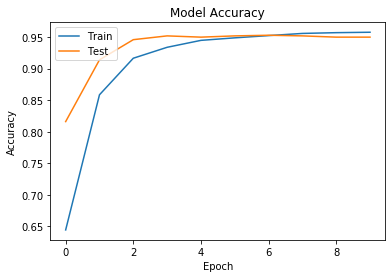

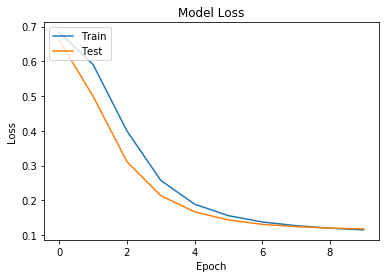

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_811 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_812 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_813 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6846 - accuracy: 0.6349 - val_loss: 0.6595 - val_accuracy: 0.8080
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5921 - accuracy: 0.8808 - val_loss: 0.5078 - val_accura

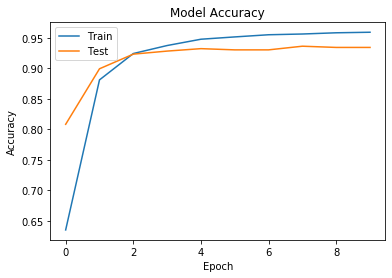

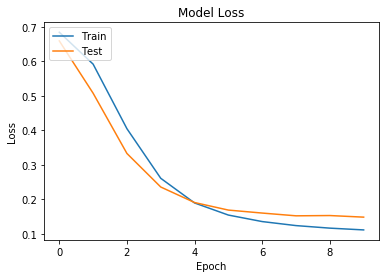

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_814 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_815 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_816 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6845 - accuracy: 0.6353 - val_loss: 0.6630 - val_accuracy: 0.7660
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.5938 - accuracy: 0.8643 - val_loss: 0.5079 - val_accura

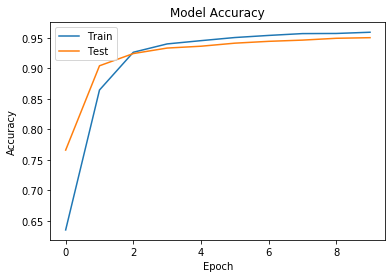

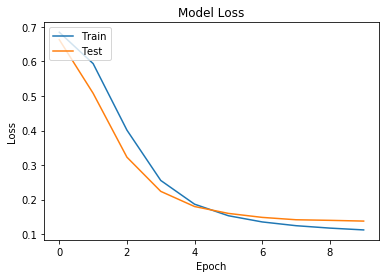

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_817 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_818 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_819 (Dense)            (None, 1)                 11        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6784 - accuracy: 0.6899 - val_loss: 0.6468 - val_accuracy: 0.8270
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5707 - accuracy: 0.8853 - val_loss: 0.4688 - val_accuracy: 0.9230
Epoch

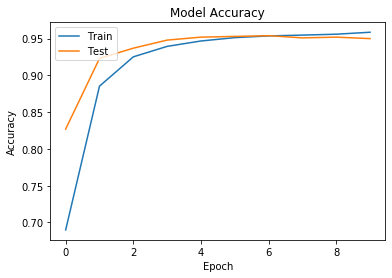

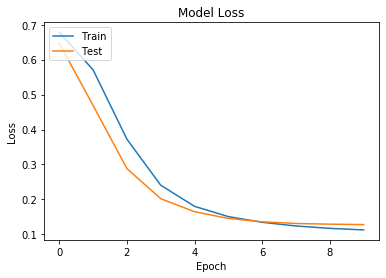

Input Dim: 500, n1: 3, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_820 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_821 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_822 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6807 - accuracy: 0.5792 - val_loss: 0.6464 - val_accuracy: 0.6700
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - l

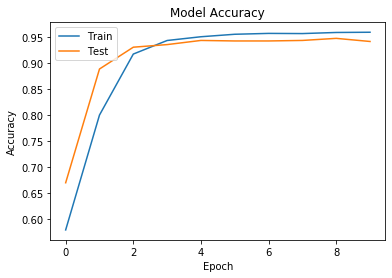

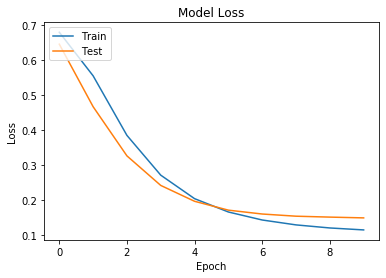

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_823 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_824 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_825 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 39us/step - loss: 0.6889 - accuracy: 0.5937 - val_loss: 0.6772 - val_accuracy: 0.7090
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6234 - accuracy: 0.8242 - val_loss: 0.5433 - val_accura

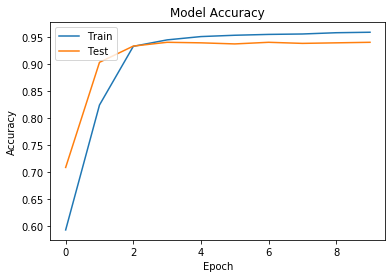

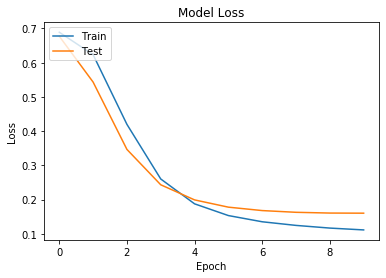

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_826 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_827 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_828 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6779 - accuracy: 0.6690 - val_loss: 0.6493 - val_accuracy: 0.7890
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5699 - accuracy: 0.8876 - val_loss: 0.4848 - val_accura

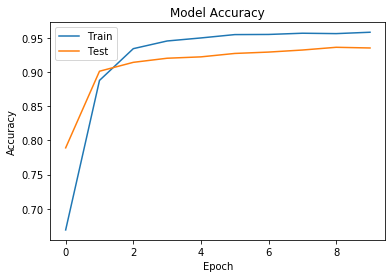

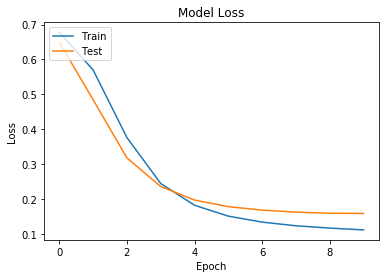

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_829 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_830 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_831 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6827 - accuracy: 0.6286 - val_loss: 0.6601 - val_accuracy: 0.7630
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5962 - accuracy: 0.8590 - val_loss: 0.5297 - val_accura

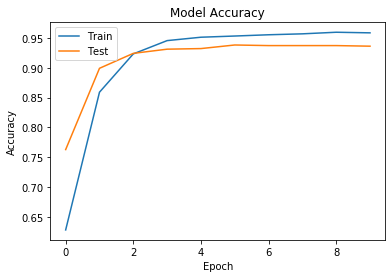

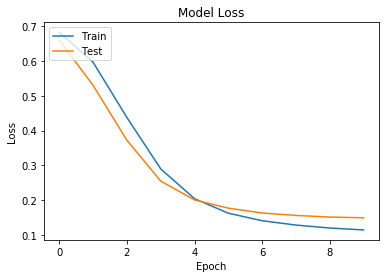

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_832 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_833 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_834 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6803 - accuracy: 0.6569 - val_loss: 0.6483 - val_accuracy: 0.8140
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.5682 - accuracy: 0.8858 - val_loss: 0.4814 - val_accura

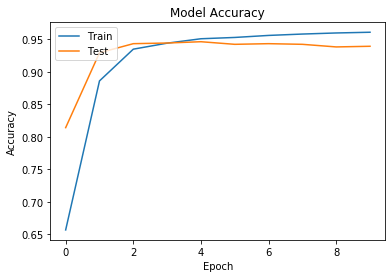

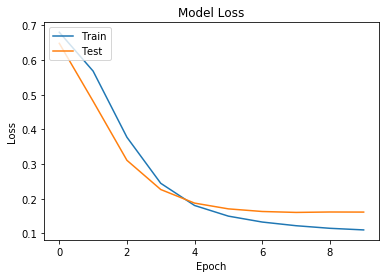

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_835 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_836 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_837 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 41us/step - loss: 0.6882 - accuracy: 0.6183 - val_loss: 0.6734 - val_accuracy: 0.8120
Epoch 2/10
9000/9000 [==============================] - 0s 23us/step - loss: 0.6317 - accuracy: 0.8749 - val_loss: 0.5679 - val_accura

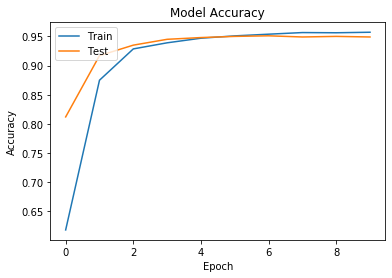

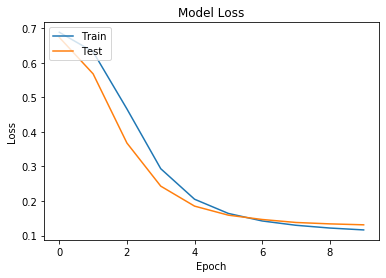

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_838 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_839 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_840 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.6848 - accuracy: 0.6174 - val_loss: 0.6620 - val_accuracy: 0.6680
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.5987 - accuracy: 0.8206 - val_loss: 0.5138 - val_accura

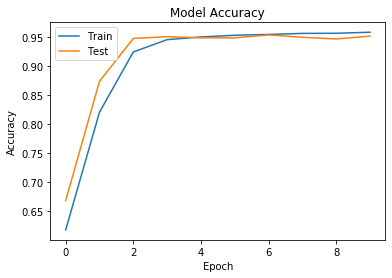

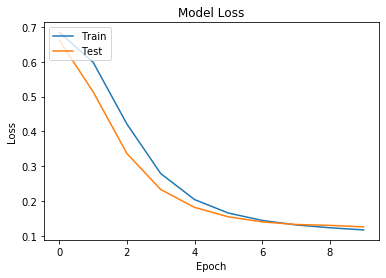

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_841 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_842 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_843 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 38us/step - loss: 0.6900 - accuracy: 0.5316 - val_loss: 0.6809 - val_accuracy: 0.7330
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6378 - accuracy: 0.8597 - val_loss: 0.5763 - val_accura

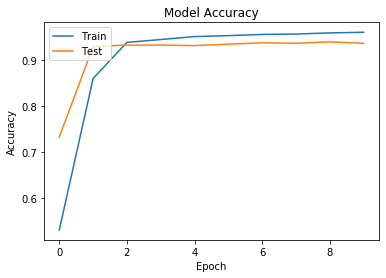

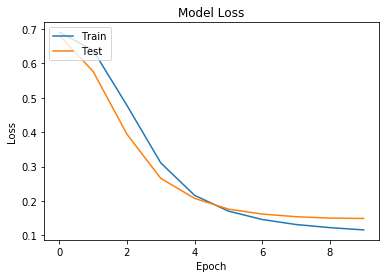

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_844 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_845 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_846 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6751 - accuracy: 0.7011 - val_loss: 0.6415 - val_accuracy: 0.8400
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.5627 - accuracy: 0.8983 - val_loss: 0.4709 - val_accura

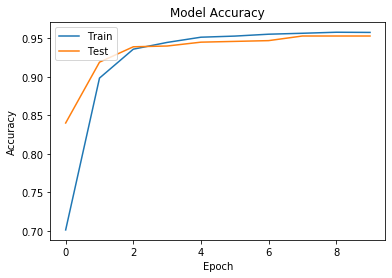

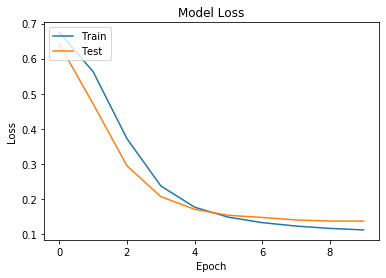

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_847 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_848 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_849 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6875 - accuracy: 0.5440 - val_loss: 0.6708 - val_accuracy: 0.6400
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6302 - accuracy: 0.6899 - val_loss: 0.5689 - val_accuracy: 0.8210
Epoch

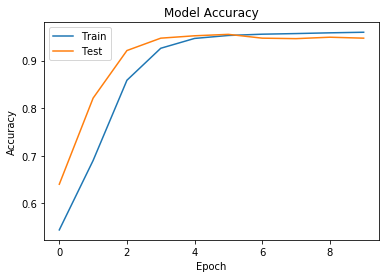

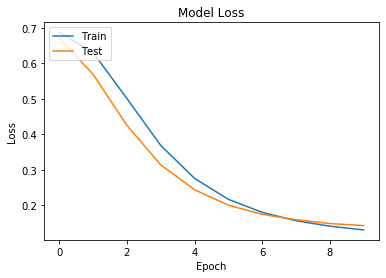

Input Dim: 500, n1: 3, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_850 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_851 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_852 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 51us/step - loss: 0.6939 - accuracy: 0.5076 - val_loss: 0.6923 - val_accuracy: 0.6150
Epoch 2/10
9000/9000 [==============================] - 0s 38us/step 

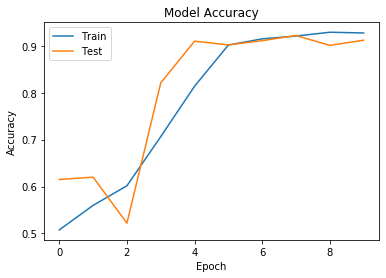

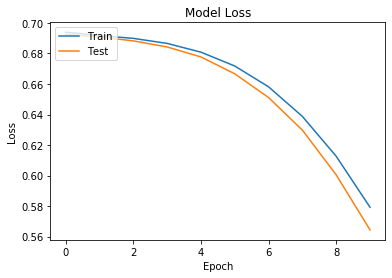

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_853 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_854 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_855 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.7894 - accuracy: 0.4997 - val_loss: 0.7140 - val_accuracy: 0.5030
Epoch 2/10
9000/9000 [==============================] - 0s 25us/step - loss: 0.6971 - accuracy: 0.4997 - val_loss: 0.6896 - val_accura

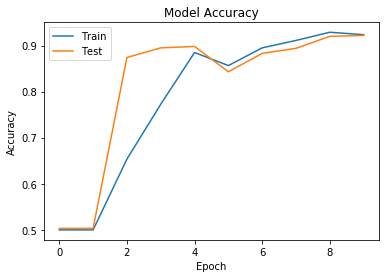

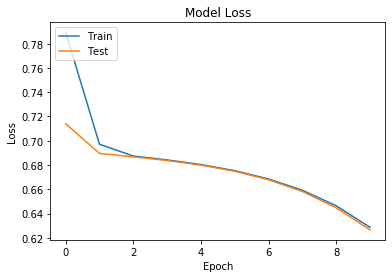

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_856 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_857 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_858 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 47us/step - loss: 0.7689 - accuracy: 0.4974 - val_loss: 0.6983 - val_accuracy: 0.5230
Epoch 2/10
9000/9000 [==============================] - 0s 25us/step - loss: 0.6966 - accuracy: 0.4974 - val_loss: 0.6922 - val_accura

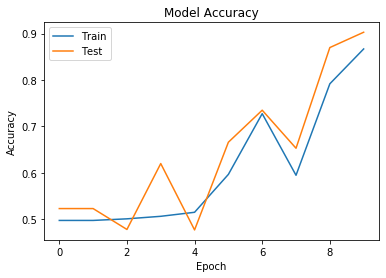

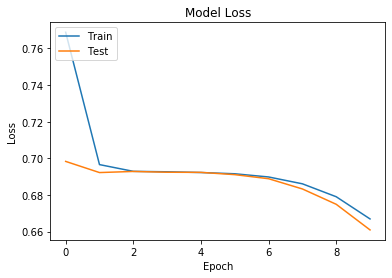

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_859 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_860 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_861 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.6939 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4820
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.6927 - accuracy: 0.5190 - val_loss: 0.6925 - val_accura

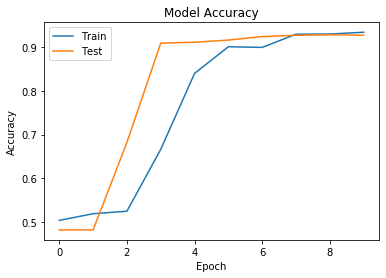

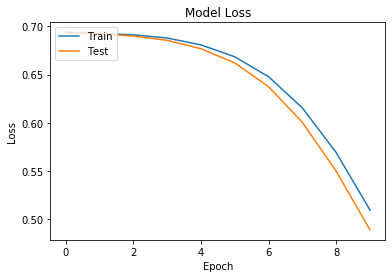

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_862 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_863 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_864 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 58us/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 2/10
9000/9000 [==============================] - 0s 25us/step - loss: 0.6920 - accuracy: 0.5570 - val_loss: 0.6914 - val_accura

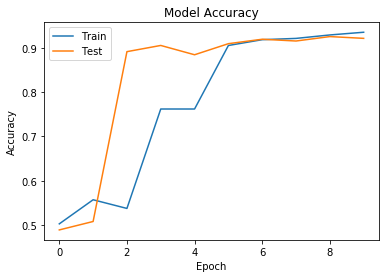

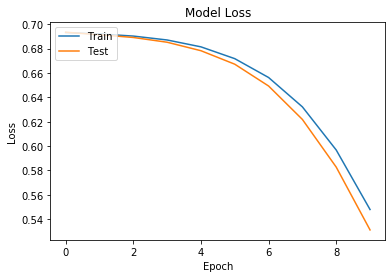

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_865 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_866 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_867 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.7134 - accuracy: 0.4971 - val_loss: 0.6912 - val_accuracy: 0.5260
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.6928 - accuracy: 0.5110 - val_loss: 0.6915 - val_accura

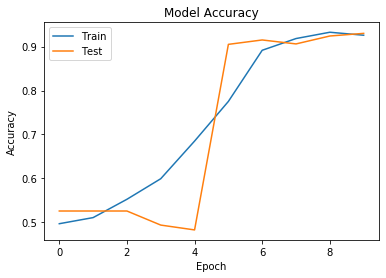

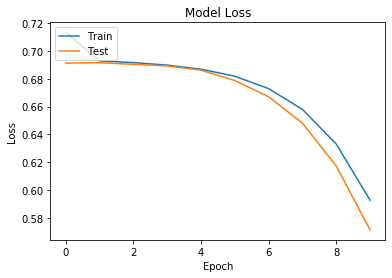

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_868 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_869 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_870 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6934 - accuracy: 0.5233 - val_loss: 0.6918 - val_accuracy: 0.5130
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.6915 - accuracy: 0.5590 - val_loss: 0.6904 - val_accura

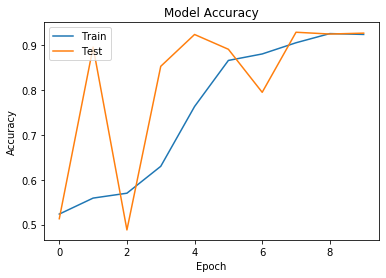

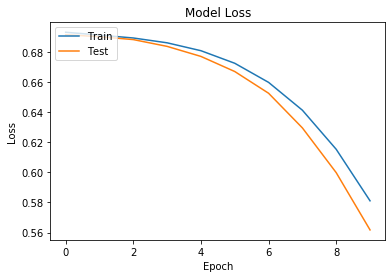

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_871 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_872 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_873 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.7270 - accuracy: 0.5028 - val_loss: 0.7018 - val_accuracy: 0.4750
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.6922 - accuracy: 0.5028 - val_loss: 0.6911 - val_accura

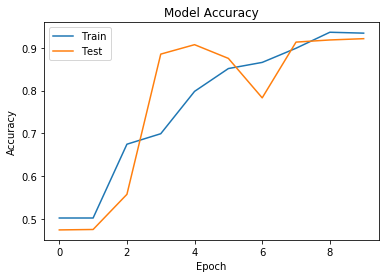

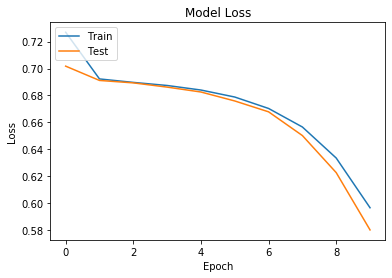

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_874 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_875 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_876 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6967 - accuracy: 0.5203 - val_loss: 0.6920 - val_accuracy: 0.7320
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6914 - accuracy: 0.5563 - val_loss: 0.6906 - val_accura

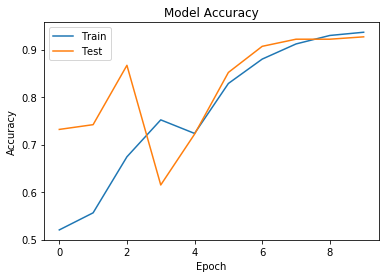

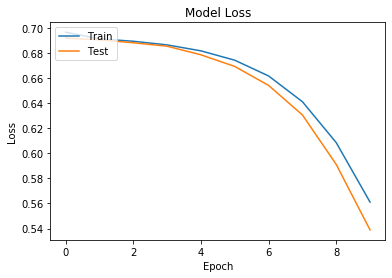

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_877 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_878 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_879 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.7104 - accuracy: 0.4983 - val_loss: 0.6914 - val_accuracy: 0.5150
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.6913 - accuracy: 0.5418 - val_loss: 0.6908 - val_accuracy: 0.4850
Epoch

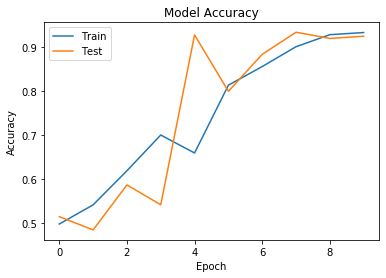

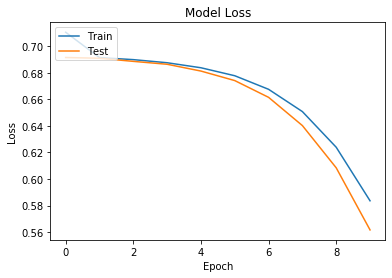

Input Dim: 500, n1: 3, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_880 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_881 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_882 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6779 - accuracy: 0.6992 - val_loss: 0.6418 - val_accuracy: 0.8320
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - l

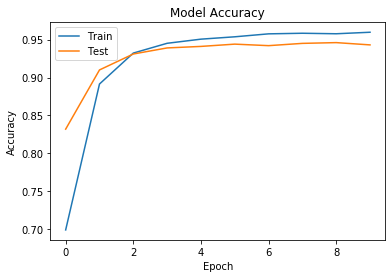

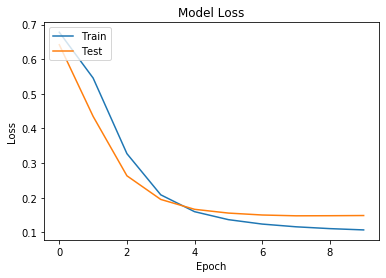

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_883 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_884 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_885 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.6611 - accuracy: 0.7117 - val_loss: 0.6203 - val_accuracy: 0.8220
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.5074 - accuracy: 0.8943 - val_loss: 0.4240 - val_accura

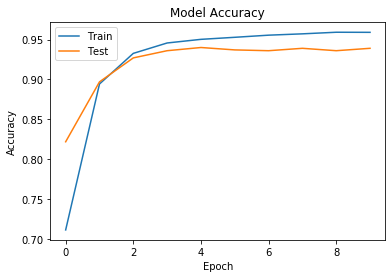

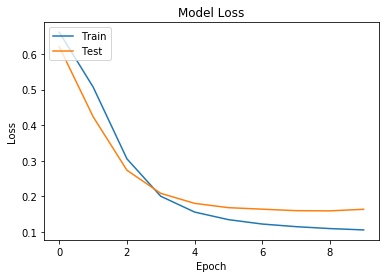

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_886 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_887 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_888 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 36us/step - loss: 0.6808 - accuracy: 0.6328 - val_loss: 0.6517 - val_accuracy: 0.7980
Epoch 2/10
9000/9000 [==============================] - 0s 27us/step - loss: 0.5647 - accuracy: 0.8842 - val_loss: 0.4702 - val_accura

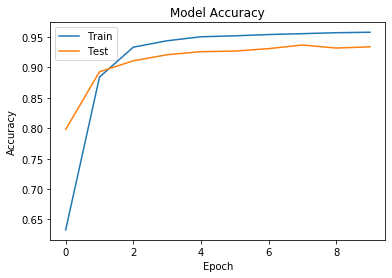

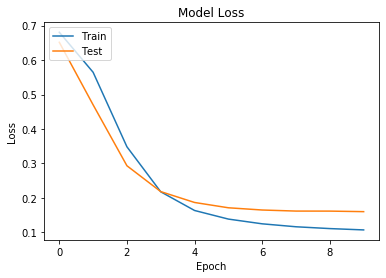

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_889 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_890 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_891 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 41us/step - loss: 0.6678 - accuracy: 0.6844 - val_loss: 0.6208 - val_accuracy: 0.8370
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.5189 - accuracy: 0.8993 - val_loss: 0.4228 - val_accura

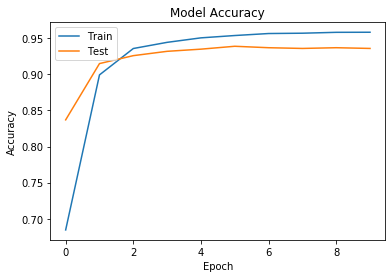

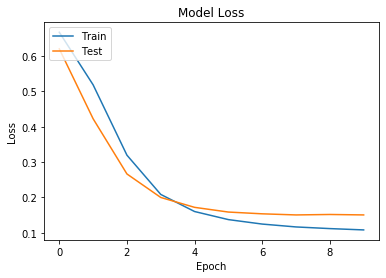

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_892 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_893 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_894 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 33us/step - loss: 0.6670 - accuracy: 0.6721 - val_loss: 0.6167 - val_accuracy: 0.8290
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.5124 - accuracy: 0.8917 - val_loss: 0.4057 - val_accura

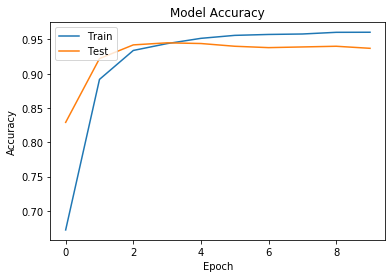

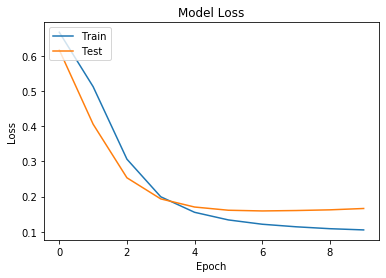

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_895 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_896 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_897 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 39us/step - loss: 0.6761 - accuracy: 0.6537 - val_loss: 0.6349 - val_accuracy: 0.8350
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5362 - accuracy: 0.8909 - val_loss: 0.4207 - val_accura

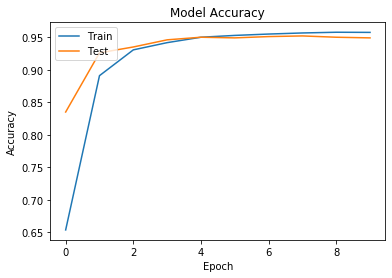

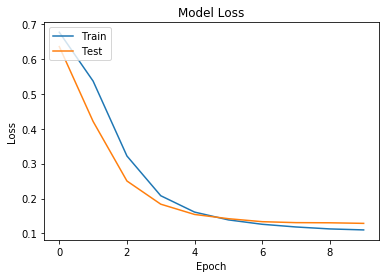

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_898 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_899 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_900 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6625 - accuracy: 0.6967 - val_loss: 0.6102 - val_accuracy: 0.8420
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5150 - accuracy: 0.8888 - val_loss: 0.4042 - val_accura

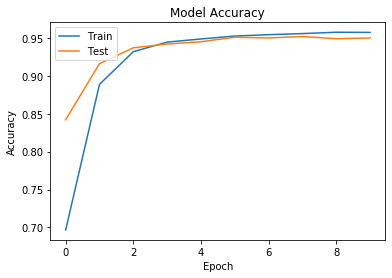

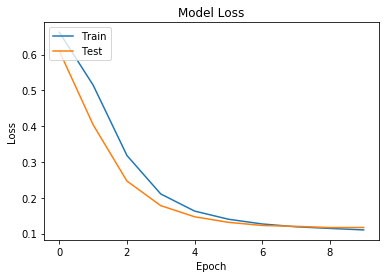

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_901 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_902 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_903 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6701 - accuracy: 0.6937 - val_loss: 0.6308 - val_accuracy: 0.7920
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5203 - accuracy: 0.8949 - val_loss: 0.4178 - val_accura

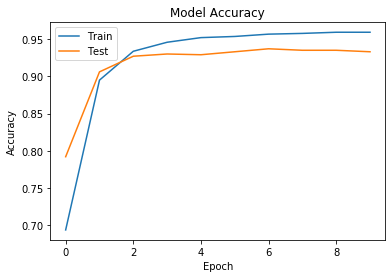

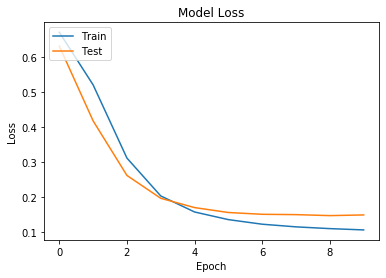

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_904 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_905 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_906 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 41us/step - loss: 0.6750 - accuracy: 0.6648 - val_loss: 0.6308 - val_accuracy: 0.8300
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.5252 - accuracy: 0.8922 - val_loss: 0.4125 - val_accura

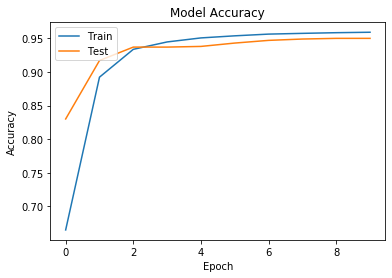

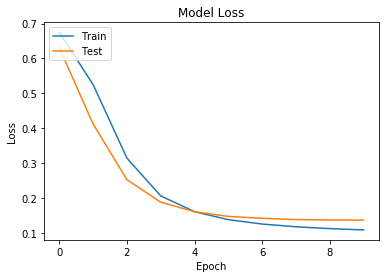

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_907 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_908 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_909 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6822 - accuracy: 0.6069 - val_loss: 0.6488 - val_accuracy: 0.7960
Epoch 2/10
9000/9000 [==============================] - 0s 17us/step - loss: 0.5585 - accuracy: 0.8828 - val_loss: 0.4418 - val_accuracy: 0.9110
Epoch

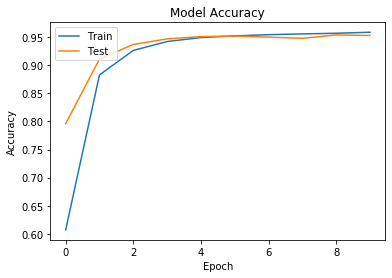

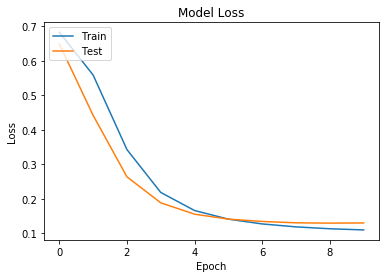

/Users/karangm/PycharmProjects/sentiment_analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/karangm/PycharmProjects/sentiment_analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [44]:
# def run_3_4(train_filenames, train_data, train_labels):
train_df, test_df, feature_names, selected_model_parameters = run_3_4_1(train_filenames, train_data,
                                                             train_labels, test_filenames, test_data)

In [45]:
svd = run_3_4_2(train_df, svd_selected_model_parameters)

Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_910 (Dense)            (None, 3)                 1503      
_________________________________________________________________
dense_911 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_912 (Dense)            (None, 1)                 11        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Validation/Test set is not given
Epoch 1/10
10000/10000 [==============================] - 0s 30us/step - loss: 0.6839 - accuracy: 0.6053
Epoch 2/10
10000/10000 [==============================] - 0s 18us/step - loss: 0.5927 - accuracy: 0.8786
Epoch 3/10
10000/10000 [==============================] - 0s 17us/step - loss: 0.4095 - accuracy: 0.9356
Epoch 4/10
10000/10000 [========

In [46]:
svd_selected_model_parameters

{'val_accuracy': 0.9439999997615814,
 'n1': 3,
 'n2': 10,
 'activation': 'relu',
 'n2_activation': 'sigmoid',
 'components': 500}

### 3.5 [5 points]
Using the optimal number of components you found in 3.4, apply TF-IDF and SVD on the whole training set. Report the top 5 topics and the 20 most important words in each topic.

Hint: Each topic is the component you get from SVD. To get top 5 components: 
i) first sort the singular values in decreasing order (use the singular value function from sklearn’s SVD), 
ii) then, pick the first five components corresponding to those sorted singular values.

In [47]:
def run_3_5(feature_names, svd_model):
    for i, component in enumerate(svd_model.components_):
        # Iterating over the topics
        if i == 5:
            break
        feature_names_component = zip(feature_names, component)
        sorted_terms = sorted(feature_names_component, key= lambda x:x[1], reverse=True)
        print("Topic "+str(i)+": ")
        ## Getting the top 20 words
        word_count = 0
        words = ""
        for t in sorted_terms:
            word_count = word_count + 1
            if word_count == 20:
                break
            words = words + t[0] + " "
        print(words)

In [48]:
run_3_5(feature_names, svd)

Topic 0: 
the and to was it we of is for my in they this that you with not food have 
Topic 1: 
we was our were us she he had to minutes told came said her asked after didn got ordered 
Topic 2: 
to me they you my she he that have car them your get do if told her call up 
Topic 3: 
we our great and us always are friendly is love service amazing staff he have very you recommend been 
Topic 4: 
was and my great she very he me her friendly amazing recommend hair definitely highly service professional staff his 


### 3.6 [5 points]

Using the best model from above (based on results from 3.2, 3.3., and 3.4), predict the sentiment scores for all 495 reviews in this test set: http://bit.ly/2m0Hxsg

Classify the reviews into two categories based on your predicted sentiment score, as shown in the training data. Submit two text files: 
i) “pos.txt”, with a list of file names for reviews predicted as positive, 
ii) “neg.txt”, with a list of file names for reviews predicted as negative. 

Put each file name in a separate line. Submit a folder of these two text files and name the folder as labels. (For
grading purpose, please DO NOT change the file names of the reviews.)

In [66]:
def run_3_6(test_df, test_filenames, svd):
        
    temp_pos_output_file = open('../output/labels/pos.txt', 'w')
    temp_neg_output_file = open('../output/labels/neg.txt', 'w')
    
    test_x_df, test_y_df = get_x_y(test_df)
    
    # SVD - Transforming using the same model
    test_x_transformed_array = svd.transform(test_x_df)        

    # create a dataframe to reuse existing functions
    test_x_transformed_df = pd.DataFrame(test_x_transformed_array)
    
    # Load the model
    model = load_model('../output/svd.h5')
    test_y_hat = model.predict_classes(test_x_transformed_df)

    test_y_hat = test_y_hat.flatten()
    for i in range(len(test_y_hat)):
        if test_y_hat[i] == 1:
            temp_neg_output_file.write(test_filenames[i] + "\n")
        else:
            temp_pos_output_file.write(test_filenames[i] + "\n")

In [67]:
run_3_6(test_df, test_filenames, svd)